In [1]:
import yfinance as yf
import pandas as pd

In [2]:
def fetch_stock_data(tickers=["JPM"], start="2000-01-01", end="2021-12-31"):
    """
    Fetches stock data for the specified tickers and time period using the yfinance library.

    Parameters:
    tickers (list): A list of stock tickers (default is ["JPM"]).
    start (str): The start date for fetching data in the format YYYY-MM-DD (default is "2000-01-01").
    end (str): The end date for fetching data in the format YYYY-MM-DD (default is "2021-12-31").

    Returns:
    data (pd.DataFrame): A pandas DataFrame containing the fetched stock data.
    """

    # Combine data for all tickers into a single DataFrame
    data = pd.DataFrame()
    for ticker in tickers:
        stock_data = yf.download(ticker, start=start, end=end)
        stock_data["Ticker"] = ticker
        data = data.append(stock_data, sort=True)

    # Reset the index and return the final DataFrame
    data.reset_index(inplace=True)
    return data

In [3]:
stock_data = fetch_stock_data(tickers=["JPM", "AAPL"], start="2010-01-01", end="2023-3-27")
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed


<ipython-input-2-613dc12deb2b>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(stock_data, sort=True)


[*********************100%%**********************]  1 of 1 completed
        Date  Adj Close      Close       High        Low       Open Ticker  \
0 2010-01-04  30.073074  42.849998  42.990002  41.669998  41.790001    JPM   
1 2010-01-05  30.655596  43.680000  43.840000  42.779999  42.790001    JPM   
2 2010-01-06  30.824030  43.919998  44.090000  43.310001  43.450001    JPM   
3 2010-01-07  31.434610  44.790001  45.119999  43.610001  43.790001    JPM   
4 2010-01-08  31.357414  44.680000  44.700001  44.080002  44.369999    JPM   

     Volume  
0  35460500  
1  41208300  
2  27729000  
3  44864700  
4  33110100  


<ipython-input-2-613dc12deb2b>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(stock_data, sort=True)


In [4]:
def add_target_column(data, target_col="Target"):
    """
    Adds a target column to the input DataFrame, indicating whether the previous day's closing price was up or down.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing stock data.
    target_col (str): The name of the target column to be added (default is "Target").

    Returns:
    data (pd.DataFrame): The DataFrame with the new target column added.
    """

    # Calculate the difference between consecutive closing prices
    data["Price_Diff"] = data["Close"].diff()

    # Assign "UP" or "DOWN" based on the sign of the price difference
    data[target_col] = data["Price_Diff"].apply(lambda x: "UP" if x > 0 else "DOWN")

    # Drop the first row since it has no previous day to compare to, and the "Price_Diff" column
    data = data.drop(0).drop(columns=["Price_Diff"])

    return data

In [5]:
stock_data_with_target = add_target_column(stock_data)
print(stock_data_with_target.head())

        Date  Adj Close      Close       High        Low       Open Ticker  \
1 2010-01-05  30.655596  43.680000  43.840000  42.779999  42.790001    JPM   
2 2010-01-06  30.824030  43.919998  44.090000  43.310001  43.450001    JPM   
3 2010-01-07  31.434610  44.790001  45.119999  43.610001  43.790001    JPM   
4 2010-01-08  31.357414  44.680000  44.700001  44.080002  44.369999    JPM   
5 2010-01-11  31.252140  44.529999  45.189999  44.310001  45.119999    JPM   

     Volume Target  
1  41208300     UP  
2  27729000     UP  
3  44864700     UP  
4  33110100   DOWN  
5  31878700   DOWN  


In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [7]:
def encode_and_preprocess(data, categorical_cols=None, numerical_cols=None, target_col="Target"):
    """
    Encodes categorical variables and standardizes/normalizes numerical variables in the input DataFrame.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing stock data.
    categorical_cols (list): A list of categorical column names to be encoded (default is None).
    numerical_cols (list): A list of numerical column names to be standardized/normalized (default is None).
    target_col (str): The name of the target column (default is "Target").

    Returns:
    data (pd.DataFrame): The preprocessed DataFrame.
    """

    # Make a copy of the input DataFrame to avoid modifying the original data
    data = data.copy()

    # Encode categorical columns
    if categorical_cols:
        le = LabelEncoder()
        for col in categorical_cols:
            data[col] = le.fit_transform(data[col])

    # Standardize/normalize numerical columns
    if numerical_cols:
        scaler = StandardScaler()
        data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

    # Ensure the target column is the last column in the DataFrame
    data = data[[col for col in data.columns if col != target_col] + [target_col]]

    return data

In [8]:
preprocessed_data = encode_and_preprocess(stock_data_with_target, categorical_cols=["Ticker"], numerical_cols=["Open", "High", "Low", "Close", "Adj Close", "Volume"])
print(preprocessed_data.head())

        Date  Adj Close     Close      High       Low      Open  Ticker  \
1 2010-01-05  -0.672307 -0.526017 -0.531653 -0.536036 -0.545151       1   
2 2010-01-06  -0.668595 -0.520811 -0.526288 -0.524411 -0.530830       1   
3 2010-01-07  -0.655138 -0.501939 -0.504183 -0.517830 -0.523452       1   
4 2010-01-08  -0.656840 -0.504325 -0.513196 -0.507521 -0.510866       1   
5 2010-01-11  -0.659160 -0.507579 -0.502680 -0.502476 -0.494592       1   

     Volume Target  
1 -0.489056     UP  
2 -0.557981     UP  
3 -0.470359     UP  
4 -0.530465   DOWN  
5 -0.536762   DOWN  


In [9]:
import time
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [10]:
def evaluate_classifiers(data, target_col="Target", test_size=0.2, random_state=42, exclude_columns=None):
    """
    Trains and evaluates various classifiers on the input DataFrame, displaying performance metrics and training time.

    Parameters:
    data (pd.DataFrame): The preprocessed DataFrame containing stock data.
    target_col (str): The name of the target column (default is "Target").
    test_size (float): The proportion of the dataset to include in the test split (default is 0.2).
    random_state (int): A random seed for reproducibility (default is 42).
    exclude_columns (list): A list of column names to be excluded from the features (default is None).

    Returns:
    performance_table (pd.DataFrame): A DataFrame displaying each algorithm's name, training time, and performance metrics.
    """

    # Exclude the specified columns from the features, if provided
    if exclude_columns:
        feature_columns = [col for col in data.columns if col not in exclude_columns + [target_col]]
    else:
        feature_columns = [col for col in data.columns if col != target_col]

    # Split the data into training and testing sets
    X = data[feature_columns]
    y = data[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(X.head(5))
    print(y.head(5))
    print(y_test.head(5))

    # Encode the target column
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # Define the classifiers to be evaluated
    classifiers = [
        ("Logistic Regression", LogisticRegression(random_state=random_state)),
        ("Decision Tree", DecisionTreeClassifier(random_state=random_state)),
        ("Random Forest", RandomForestClassifier(random_state=random_state)),
        ("Support Vector Machine", SVC(random_state=random_state, probability=True)),
        ("K-Nearest Neighbors", KNeighborsClassifier()),
        ("XGBoost", XGBClassifier(random_state=random_state)),
        ("LightGBM", LGBMClassifier(random_state=random_state)),
    ]

    # Evaluate each classifier and store the results in a list
    results = []
    for name, classifier in classifiers:
        start_time = time.time()
        classifier.fit(X_train, y_train)
        end_time = time.time()

        # Compute the performance metrics
        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:, 1]
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_proba)

        results.append([name, end_time - start_time, accuracy, precision, recall, f1, roc_auc])
    # Create a DataFrame from the results and sort it by the best AUC/ROC score
    performance_table = pd.DataFrame(results, columns=["Classifier", "Training Time", "Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"])
    performance_table = performance_table.sort_values(by="ROC AUC", ascending=False).reset_index(drop=True)

    return performance_table

In [11]:
performance_table = evaluate_classifiers(preprocessed_data, exclude_columns=["Date"])
performance_table

   Adj Close     Close      High       Low      Open  Ticker    Volume
1  -0.672307 -0.526017 -0.531653 -0.536036 -0.545151       1 -0.489056
2  -0.668595 -0.520811 -0.526288 -0.524411 -0.530830       1 -0.557981
3  -0.655138 -0.501939 -0.504183 -0.517830 -0.523452       1 -0.470359
4  -0.656840 -0.504325 -0.513196 -0.507521 -0.510866       1 -0.530465
5  -0.659160 -0.507579 -0.502680 -0.502476 -0.494592       1 -0.536762
1      UP
2      UP
3      UP
4    DOWN
5    DOWN
Name: Target, dtype: object
3333      UP
218     DOWN
4716    DOWN
2940    DOWN
1545      UP
Name: Target, dtype: object
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2774, number of negative: 2551
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train se

,Classifier,Training Time,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.032426,0.700450,0.646274,0.877644,0.744395,0.813467
1,XGBoost,0.520339,0.695946,0.684362,0.720544,0.701987,0.749759
2,LightGBM,0.101812,0.684685,0.665301,0.735650,0.698709,0.739444
3,Random Forest,2.463860,0.678679,0.676205,0.678248,0.677225,0.727745
4,Decision Tree,0.412044,0.674174,0.668639,0.682779,0.675635,0.674226
5,Support Vector Machine,4.585557,0.521021,0.509479,0.974320,0.669087,0.663187
6,K-Nearest Neighbors,0.004794,0.581832,0.575758,0.602719,0.588930,0.619178


In [12]:
from sklearn.model_selection import cross_val_score, KFold

def kfold_cross_val_scores(classifiers, X, y, scoring='roc_auc', n_splits=5, random_state=42):
    """
    Performs k-fold cross-validation for each classifier and returns their scores.

    Parameters:
    classifiers (list): List of classifiers as tuples (name, classifier_instance).
    X (pd.DataFrame): The feature matrix.
    y (pd.Series): The target variable.
    scoring (str): Scikit-learn scoring method (default is 'roc_auc').
    n_splits (int): The number of folds in k-fold cross-validation (default is 5).
    random_state (int): Random state for reproducibility (default is 42).

    Returns:
    pd.DataFrame: A DataFrame containing the classifier names and cross-validation scores.
    """
    kfold = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    scores = []

    for name, classifier in classifiers:
        cv_scores = cross_val_score(classifier, X, y, scoring=scoring, cv=kfold)
        for score in cv_scores:
            scores.append([name, score])

    scores_df = pd.DataFrame(scores, columns=["Classifier", "Score"])
    return scores_df

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt



random_state = 21
classifiers = [
    ("Logistic Regression", LogisticRegression(random_state=random_state)),
    ("Support Vector Machines", SVC(random_state=random_state, probability=True)),
    ("Random Forest", RandomForestClassifier(random_state=random_state)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric="logloss")),
    ("LightGBM", LGBMClassifier(random_state=random_state))
]
def visualize_performance(classifiers, X, y, scoring='roc_auc', n_splits=5, random_state=42):
    """
    Performs k-fold cross-validation and generates boxplots for the chosen scoring metric.

    Parameters:
    classifiers (list): List of classifiers as tuples (name, classifier_instance).
    X (pd.DataFrame): The feature matrix.
    y (pd.Series): The target variable.
    scoring (str): Scikit-learn scoring method (default is 'roc_auc').
    n_splits (int): The number of folds in k-fold cross-validation (default is 5).
    random_state (int): Random state for reproducibility (default is 42).
    """

    # Obtain the k-fold cross-validation scores
    scores_df = kfold_cross_val_scores(classifiers, X, y, scoring=scoring, n_splits=n_splits, random_state=random_state)

    # Create a boxplot for the chosen scoring metric
    plt.figure(figsize=(14, 6))
    sns.boxplot(x="Classifier", y="Score", data=scores_df, palette="Set2")
    plt.title(f"Classifier {scoring.upper()} Comparison (k-Fold Cross-Validation)")
    plt.xticks(rotation=45)
    plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2774, number of negative: 2551
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 5325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520939 -> initscore=0.083805
[LightGBM] [Info] Start training from score 0.083805
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2750, number of negative: 2575
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

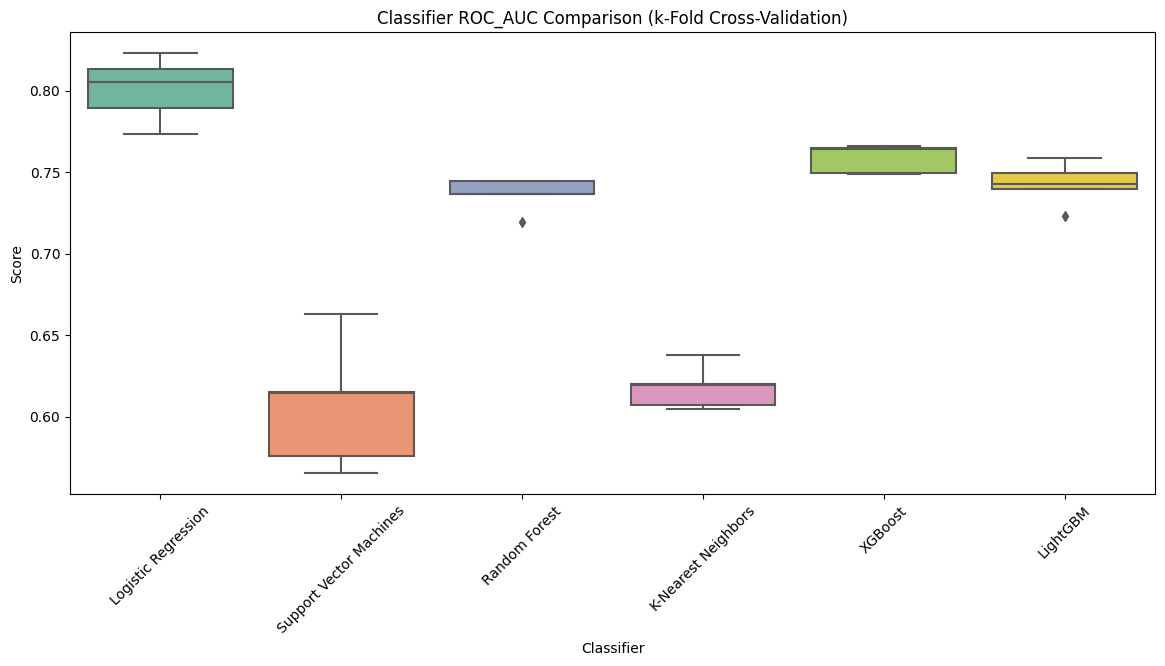

In [14]:
# Prepare the data
X = preprocessed_data.drop(["Date", "Target"], axis=1)
y = preprocessed_data["Target"]

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Visualize the performance
visualize_performance(classifiers, X, y_encoded, scoring='roc_auc')

In [15]:
def encode_data(data):
    # This function should implement your encoding logic
    # For example, you can use LabelEncoder, OneHotEncoder, or any other suitable encoding method
    # Here's a simple example using LabelEncoder:

    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    encoded_data = data.copy()

    for col in encoded_data.columns:
        if encoded_data[col].dtype == 'object':
            encoded_data[col] = le.fit_transform(encoded_data[col])

    return encoded_data

In [16]:
from sklearn.preprocessing import StandardScaler

def normalize_data(data):
    # This function should implement your normalization logic
    # For example, you can use StandardScaler, MinMaxScaler, or any other suitable method
    # Here's an example using StandardScaler:

    scaler = StandardScaler()
    normalized_data = data.copy()

    for col in normalized_data.columns:
        if normalized_data[col].dtype != 'object' and col != "Date":
            normalized_data[col] = scaler.fit_transform(normalized_data[[col]])

    return normalized_data

In [17]:
# Modify the predict_new_data function to use the encoding and normalization functions

def predict_new_data(model, new_data):
    # Encode categorical variables and normalize numerical variables
    encoded_new_data = encode_data(new_data)
    normalized_new_data = normalize_data(encoded_new_data)

    # Get the feature names from the trained model
    feature_names = X.columns.tolist()

    # Remove columns that are not in the training data
    for col in normalized_new_data.columns:
        if col not in feature_names:
            normalized_new_data.drop(columns=[col], inplace=True)

    # Add missing columns from the training data and fill them with zeros
    for col in feature_names:
        if col not in normalized_new_data.columns:
            normalized_new_data[col] = 0

    # Ensure the columns are in the same order as the training data
    normalized_new_data = normalized_new_data[feature_names]

    # Make predictions
    predictions = model.predict(normalized_new_data)

    return predictions

In [22]:
# Train the best model on the entire dataset
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X, y_encoded)

RandomForestClassifier(random_state=42)

In [23]:
# Create a sample DataFrame with new data
sample_data = {
    "Open": [150.0, 152.0, 153.5],
    "High": [153.0, 155.0, 156.0],
    "Low": [149.0, 150.0, 151.0],
    "Close": [151.0, 154.0, 152.0],
    "Volume": [2000000, 2500000, 1800000],
    "Dividends": [0.0, 0.0, 0.0],
    "Stock Splits": [0, 0, 0]
}

new_data = pd.DataFrame(sample_data)

# Make predictions using the trained best model
predictions = predict_new_data(best_model, new_data)

# Print the predictions
print(predictions)

[1 1 0]


In [24]:
from sklearn.model_selection import GridSearchCV

def optimize_hyperparameters(model, param_grid, X, y, cv=5, scoring='roc_auc'):
    """
    This function performs grid search to optimize hyperparameters for a given model.

    :param model: The model for which to optimize hyperparameters
    :param param_grid: A dictionary containing the hyperparameters and their possible values
    :param X: The feature matrix
    :param y: The target variable
    :param cv: The number of cross-validation folds (default: 5)
    :param scoring: The scoring metric used for optimization (default: 'roc_auc')
    :return: The best model found by grid search
    """
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)

    print(f"Best {scoring} score: {grid_search.best_score_}")
    print("Best hyperparameters:")
    for key, value in grid_search.best_params_.items():
        print(f"  {key}: {value}")

    return grid_search.best_estimator_

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Optimize the hyperparameters for the best model
best_model_optimized = optimize_hyperparameters(best_model, param_grid, X, y)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


In [28]:
def retrain_and_compare_baseline_optimized(best_model, best_model_optimized, X, y, test_size=0.25, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print(X.head(10))
    print(y.head(10))
    print(y_test.head(10))


    # Fit the baseline model
    best_model.fit(X_train, y_train)

    # Make predictions with the baseline model
    y_pred_baseline = best_model.predict(X_test)

    # Compute performance metrics for the baseline model
    accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
    # precision_baseline = precision_score(y_test, y_pred_baseline)
    # recall_baseline = recall_score(y_test, y_pred_baseline)
    # f1_baseline = f1_score(y_test, y_pred_baseline)
    # roc_auc_baseline = roc_auc_score(y_test, y_pred_baseline)

    # Fit the optimized model
    best_model_optimized.fit(X_train, y_train)

    # Make predictions with the optimized model
    y_pred_optimized = best_model_optimized.predict(X_test)

    # Compute performance metrics for the optimized model
    accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
    precision_optimized = precision_score(y_test, y_pred_optimized)
    recall_optimized = recall_score(y_test, y_pred_optimized)
    f1_optimized = f1_score(y_test, y_pred_optimized)
    roc_auc_optimized = roc_auc_score(y_test, y_pred_optimized)

    # Create a table to compare the baseline and optimized model performance
    comparison_table = pd.DataFrame(
        {
            'Model': ['Baseline', 'Optimized'],
            'Accuracy': [accuracy_baseline, accuracy_optimized],
            'Precision': [precision_baseline, precision_optimized],
            'Recall': [recall_baseline, recall_optimized],
            'F1 Score': [f1_baseline, f1_optimized],
            'ROC AUC': [roc_auc_baseline, roc_auc_optimized]
        }
    )

    return comparison_table

# Train the best model with the best parameters and compare the performance


comparison_table = retrain_and_compare_baseline_optimized(best_model, best_model_optimized, X, y)
print(comparison_table)

    Adj Close     Close      High       Low      Open  Ticker    Volume
1   -0.672307 -0.526017 -0.531653 -0.536036 -0.545151       1 -0.489056
2   -0.668595 -0.520811 -0.526288 -0.524411 -0.530830       1 -0.557981
3   -0.655138 -0.501939 -0.504183 -0.517830 -0.523452       1 -0.470359
4   -0.656840 -0.504325 -0.513196 -0.507521 -0.510866       1 -0.530465
5   -0.659160 -0.507579 -0.502680 -0.502476 -0.494592       1 -0.536762
6   -0.675245 -0.530138 -0.525000 -0.532527 -0.519112       1 -0.458880
7   -0.663491 -0.513652 -0.516845 -0.534062 -0.528660       1 -0.497167
8   -0.656685 -0.504108 -0.511265 -0.507082 -0.514555       1 -0.505776
9   -0.672307 -0.526017 -0.518991 -0.523753 -0.512385       1 -0.343170
10  -0.678494 -0.534693 -0.533584 -0.533404 -0.531915       1 -0.486380
1       UP
2       UP
3       UP
4     DOWN
5     DOWN
6     DOWN
7       UP
8       UP
9     DOWN
10    DOWN
Name: Target, dtype: object
3333      UP
218     DOWN
4716    DOWN
2940    DOWN
1545      UP
248  

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


ValueError: ignored